In [30]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import os
import seaborn as sns
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


import scipy as sp
from scipy import signal

In [31]:
# in windows: "G:/Other computers/My MacBook Air/thermal-project-data/cycling"
# in mac: "../../../Documents/thermal-project-data/cycling/"
fileToRead = []
for root, dirs, files in os.walk("../../../Documents/thermal-project-data/cycling/"):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('.MP4'):
            # print whole path of files
            fileToRead.append(os.path.join(root, file))
    
for file in fileToRead:
    print(file)

In [32]:
#testFile = ['G:/Other computers/My MacBook Air/thermal-project-data/cycling/20221014T111320.MP4'] #prasoon
#testFile = ['G:/Other computers/My MacBook Air/thermal-project-data/cycling/20221013T141554.MP4']
# 20221014T111320-clip3.MP4 - high movment:
testFile = ["../../../Documents/thermal-project-data/cycling/split/20221014T111320-clip3.MP4"]

In [33]:
frameWidth = 750
frameHeight = 750

In [74]:
# some global variables
# I know there are too many global variable. They are not bad. But I will optimise this code later after validating that what
# I am working on...actually works!

# pixel_t is a list which store n number of lists where each list is of size image_height*image_width. n is the number of frames
# the elements inside the list are pixel intensity values at that pixel
pixel_t = []

# a tuple, which stores two list. These lists corresponds to flow vector along x and y axis.
prev_delta = ()

# this variabel keeps a track of the number of times track_pixel() has run. Each list is of size image_height*image_width
count_track_pixel = 0;

# a 2D array to store the pixel history over time (or over frames) 
# the starting pixels are ofcourse 0 to height/width of the image
pixel_hist_x = np.array([np.arange(0,frameWidth*frameHeight,1)])
pixel_hist_y = np.array([np.arange(0,frameWidth*frameHeight,1)])

def track_pixel(img, flow, step=1):
    '''
    All we need is the current pixel location given the output by optical flow
    
    ''' 
    # we will change global variables
    global count_track_pixel,prev_delta,count_track_pixel,pixel_hist_x,pixel_hist_y;
    
    # get the height and the width of the frame
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    
    if count_track_pixel != 0:
        # this is not the first run of the function, so update pixel delta
        delta_x = fx-prev_delta[0]
        delta_y = fy-prev_delta[1]
    else:
        delta_x = fx
        delta_y = fy
        
    # update prev_delta for the next frame
    prev_delta = (fx, fy)
    
    # both of these variable tell me the location of pixel in the previous frame.
    current_x = x-delta_x
    current_y = y-delta_y
    
    # given the the flow vector is a float, we convert it to int so that we can have a pixel index
    current_x = np.int32(current_x)
    current_y = np.int32(current_y)
   
    #status = all((current_x >= 0) & (current_x <= 549)) & all((current_y >= 0) & (current_y <= 549))
    
    # clip pixels so that out of range pixels are not considered. We dont want pixels that are negative or greater than the 
    # size of the image
    current_x = np.clip(current_x, 0, 549)
    current_y = np.clip(current_y, 0, 549)
    
    # store the pixel location in the global array
    pixel_hist_x = np.append(pixel_hist_x, [current_x], axis=0)
    pixel_hist_y = np.append(pixel_hist_y, [current_y], axis=0)
    

    # corresponding intensity value for the previous frame
    pixel_t.append(img[current_x,current_y])
        
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    count_track_pixel +=1
    
    return img_bgr



def draw_flow(img, flow, step=16):
    
    # get the height and the width of the frame
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    # line[0] denotes information of the first pixel where -
    # - line[0][0][0] denotes the current pixel location of the 
    # - line[0][1][1] denotes the previous pixel location (curret loc-velocity vector)
    lines = np.int32(lines + 0.5)
    
    # lines[:,0,0] all x locations of current frame 
    # lines[:,0,1] all y locations of current frame
    # lines[:,1,0] all x locations of prev frame 
    # lines[:,1,1] all y locations of prev frame
    
    
    #pixel_loc_x = lines[:,1,0].clip(min=0,max=549)
    #pixel_loc_y = lines[:,1,1].clip(min=0,max=549)
    
    #pixel_t.append(img[pixel_loc_x,pixel_loc_y])
    
    #print(img[pixel_loc_x,pixel_loc_y]) 
    
    #print(lines[:,0,0]) # does not change
    #print("\n\n\n")
    
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines[50:90], 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr

def draw_hsv(flow):

    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]

    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)

    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr


In [75]:
# event to register click for the lucas kanade optical flow
def click_event(event, x, y, flags, params):
    global old_points, first_point;
    if event == cv2.EVENT_LBUTTONDOWN:
        old_points = np.array([[x,y,]], dtype=np.float32)
        first_point = old_points
        
# lucas kanade params
lk_param = dict(winSize=(350,350), maxLevel=24, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))

In [77]:
# variable to just test
flow_global = 0;
bigFrameCount = 0;
bigfailedFrameCount = 0

# Load the cascade
#haarcascade_frontalface_alt2.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('haarcascade_mcs_nose.xml')
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

for file in testFile:
    print("\n\nProcessing = {}".format(file))
    cap = cv2.VideoCapture(file)
    # get the total frame as per opencv2
    totalFrame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # get the frame rate
    fps = cap.get(cv2.CAP_PROP_FPS)
    print("Total number of frames = {}".format(totalFrame))
    # if multiple files are processed than this variable tells the total number of frames
    bigFrameCount+=totalFrame;
    # we need to forward atleast one frame so that we have a 'previous' frame for optical flow  
    fastForwardFrame = 0
    plotImages = False
    # keep a tab of the frame count
    frameNumber =  0 if fastForwardFrame == 0 else fastForwardFrame
    failedFrameCount = 0
    # move frame that we want to fast forward
    while fastForwardFrame:
        correct,prev_frame = cap.read()
        prev_frame_gray = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
        fastForwardFrame-=1;
    
    # This variable tells how many frames to process? By default its all frame i.e. totalFrame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    NosFrame = totalFrame
    # NosFrame = totalFrame
    # this variable will be reduced after each frame is processed
    frameLeft = NosFrame
    if plotImages:
        fig, ax = plt.subplots(round(np.sqrt(NosFrame)),round(np.sqrt(NosFrame)), figsize=(45,45))
    j=0;i=0
 
    correct = True
    while frameLeft and correct:
        # read the first frame of the video
        correct,frame = cap.read()
        if correct:
            # convert the first frame to grayscale
            old_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            
            # get the size of the frame
            height, width, channel = frame.shape
            
            # create a all-zeros mask, we are doing this to get all the pixels covered by the circle
            mask = np.zeros((height, width), np.uint8)
            
            # Detect faces
            faces = face_cascade.detectMultiScale(old_gray, 1.1, 2,0,(100,100))
            print(faces)
            if isinstance(faces, tuple):
                print("No Face Detected In Frame {}".format(frameNumber))
                failedFrameCount+=1
            
            if frameNumber%100 == 0:
                print("\nDone {} out of {}".format(frameNumber, totalFrame))
                print("Failed Frame Till Now {}".format(failedFrameCount))

            # Create a mask image for drawing purposes
            mask = np.zeros_like(old_gray)

            
            for (x, y, w, h) in faces:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

                # create the circle with new point over the mask as well
                rec_mask = cv2.rectangle(mask, (x, y), (x+w, y+h), (255, 0, 0), -1)

                #and AND-AND operation between old_gray and old_gray only in the region selected by rec_mask
                masked_data = cv2.bitwise_and(old_gray,old_gray,mask=rec_mask)

                # code to get all pixel location inside the ROI in the optical flow
                # recall that rec_mask and mask are same since the cv2.rec operation is an inline op.
                # returns the threshold, output_image
                th, op_img = cv2.threshold(mask, 1,255, cv2.THRESH_BINARY)

                # input to cv2.findcontour should ideally be a binary image
                # with RETR_EXTERNAL will get the outermost contour without any  hierarchy
                # with CHAIN_APPROX_SIMPLE, only endpoints will be stored
                # ideally there should be only 4 points in the contour, one point for each vertex of the square shape
                # i.e. len(contour[0]) == 4 is ideal
                contours, _ = cv2.findContours(op_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # cv2.boundingRect expects a countor as input. Recall that the contour is a tuple and its first
                # element is the contour
                # returns x,y, width, height for a rectangle
                x,y,w,h = cv2.boundingRect(contours[0])

                # careful here. We are trying to fix the size of the image by relying on the starting point-
                # - of the contours. 
                h = frameHeight
                w = frameWidth
                roi = old_gray[y:y+h,x:x+w]
                cv2.imshow('image',roi)
        
                if len(contours[0]) >= 1 and roi.shape[0]>=frameHeight:
                    #print("Size of frame = {}".format(roi.shape))
                    
                    # calculate dense optical flow of the ROI only if this ROI is not the first ROI that we are processing
                    # We need to be on the second frame to have a flow vector from the first frame
                    if frameNumber != 0:
                        try:
                            flow = cv2.calcOpticalFlowFarneback(roi_old,roi, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                            flow_global = flow
                            #cv2.circle(roi, (int(x_i),int(y_i)),2,(0,0,255),-1)
                        except:
                            print("Frame Exception in Frame Number {}".format(frameNumber))
                            continue
                    else:
                        continue
                        # this is the first frame and our frame of interest to indicate the ROI.
                        # LK: show the first frame, so the the user can click the pixel of interest
                        #cv2.imshow('image', roi)
                        # LK:optical flow pixel click
                        #cv2.setMouseCallback('image', click_event)
                        # LK: wait infinitely until a key is pressed.
                        #cv2.waitKey(0)
                        #x_i, y_i = first_point.ravel()
                        #print(x_i, y_i)
                        
                    
                    roi_old = roi
                  
                    #cv2.imshow("Frame", roi)
                    if frameNumber != 0:
                        frame = track_pixel(roi, flow, 1)
                        cv2.circle(frame, (int(x_i),int(y_i)),5,(0,0,255),-1)
                        cv2.imshow('flow', frame)
                        #cv2.imshow('flow HSV',draw_hsv(flow))
                        #key = cv2.waitKey(int((1/fps)*1000))
                        #key = cv2.waitKey(1)
                else:
                    print("Skipped Frame No. {} in calculating sum".format(frameNumber))
                    
                if plotImages:    
                    ax[j,i].imshow(roi)
                    ax[j,i].set_title("Frame No. {}".format(frameNumber))
                    i+=1;
                    if i==round(np.sqrt(NosFrame)):
                        i=0
                        j+=1
                        
                        
            frameLeft-=1; frameNumber+=1
              
        else:
            cap.release()
            cv2.destroyAllWindows()
            print("Gracefully Closed, Error!")
            break;
            
        key = cv2.waitKey(int((1/fps)*10000)) 
        if key == 27 or key == ord('q'):
            break

    bigfailedFrameCount+=failedFrameCount
    cap.release()
    cv2.destroyAllWindows()
    print("Completed = {}".format(file))



Processing = ../../../Documents/thermal-project-data/cycling/split/20221014T111320-clip3.MP4
Total number of frames = 525.0
[[186 231 711 711]]

Done 0 out of 525.0
Failed Frame Till Now 0
[[186 231 711 711]]
Frame Exception in Frame Number 1
[[557 222 242 242]]
Frame Exception in Frame Number 2
[[286 124 730 730]]
Frame Exception in Frame Number 3
()
No Face Detected In Frame 4
[[129 229 722 722]]
Frame Exception in Frame Number 5
[[ 15 112 260 260]
 [167 201 639 639]]
Frame Exception in Frame Number 6
Frame Exception in Frame Number 6
[[227 152 694 694]]
Frame Exception in Frame Number 7
[[264 228 664 664]]
Frame Exception in Frame Number 8
[[235  99 711 711]]
Frame Exception in Frame Number 9
[[452 192 252 252]]
Frame Exception in Frame Number 10
[[408 173 273 273]
 [127 188 693 693]]
Frame Exception in Frame Number 11
Frame Exception in Frame Number 11
[[165 207 676 676]]
Frame Exception in Frame Number 12
[[  76 1316  106  106]
 [ 555  178  252  252]]
Skipped Frame No. 13 in cal

In [ ]:
frameNumber

In [9]:
pixel_t = np.array(pixel_t)

In [16]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [65]:
count = 0
concernedPixels = []
for pixelNo in range(0,pixel_t.shape[1]):
    
    size = 20
    window = sp.signal.gaussian(M=size, std=10)
    window /= window.sum()
    filteredA = np.convolve(pixel_t[:,pixelNo], window, mode='same')
    
    
    F,A = compute_fft(filteredA, fps)
    highestFreq = F[np.argmax(A[1:])+1]
    if highestFreq >= 0.2 and highestFreq <= 0.4:
        concernedPixels.append(pixelNo)
        print(pixelNo, highestFreq)
        count+=1
print("{} entried found".format(count))

1131 0.23056913993149886
1171 0.22520706690983608
3390 0.2359312129531616
7209 0.22520706690983608
8860 0.21448292086651055
9408 0.24665535899648713
16557 0.2091208478448478
17107 0.2091208478448478
127925 0.24129328597482436
128475 0.24129328597482436
129025 0.24129328597482436
129028 0.24129328597482436
129577 0.24129328597482436
129578 0.24129328597482436
129579 0.24129328597482436
130127 0.24129328597482436
130128 0.24129328597482436
130129 0.24129328597482436
130677 0.24129328597482436
130678 0.24129328597482436
130679 0.24129328597482436
131227 0.24129328597482436
131228 0.24129328597482436
131229 0.24129328597482436
131230 0.24129328597482436
131232 0.24129328597482436
131234 0.24129328597482436
131777 0.24129328597482436
131778 0.24129328597482436
131780 0.24129328597482436
131781 0.24129328597482436
131782 0.24129328597482436
131784 0.24129328597482436
131785 0.24129328597482436
132327 0.24129328597482436
132331 0.24129328597482436
132332 0.24129328597482436
132334 0.241293285

In [ ]:
# 1569

0.036916969033975934


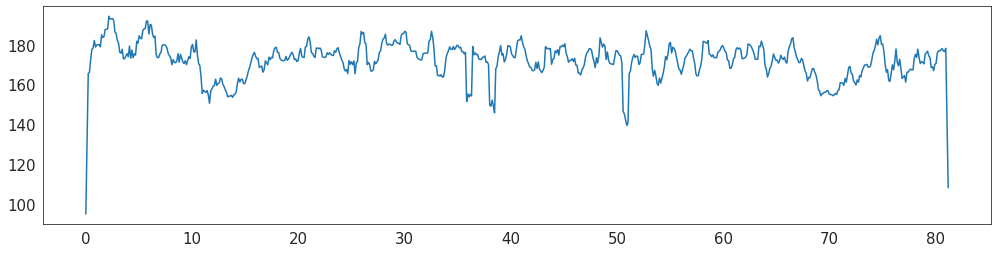

In [19]:
size = 5
window = sp.signal.gaussian(M=size, std=10)
window /= window.sum()
filteredA = np.convolve(pixel_t[:,139432], window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,pixel_t.shape[0])], filteredA)
#ax.set_xlim(0,180)
F,A = compute_fft(filteredA, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)

In [38]:
fps

8.761627317396956

In [73]:
0.2*60

12.0